Trying two methods to address unbalanced classes, using the built in class_weight="auto" which uses a simple inverse frequency weighting, and SMOTE rebalancing

I am using StandardScaler to scale the data

Scaling and weighting classes pushed accuracy and precision down, which makes sense. With strongly unbalanced data, it makes sense to always guess for the over-weighted outcome

Even though these models now are less accurate, they are more informative


In [63]:
# Much of this code is courtesy of Jonathan Dinu.

from __future__ import division
from sklearn.cross_validation import train_test_split,cross_val_score,KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,precision_score,recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
def roc_curve(model,X,y,fit=False):
    
    if fit:
        X_train,X_test,y_train,y_test = train_test_split(X,y)
        f_model = model().fit(X_train,y_train)
        probabilities = f_model.predict_proba(X_test)[:,1]
        y_true = y_test
    else:
        probabilities = model.predict_proba(X)[:,1]
        y_true = y
    
    tpr,fpr,thresholds = [],[],[]    
    ind = probabilities.argsort()
    probabilities = [probabilities[i] for i in ind] 
    labels = [y_true[i] for i in ind] 
    for thresh in probabilities:
        thresholds.append(thresh)
        pos = len([i for i in y_true if i == 1])
        neg = len([i for i in y_true if i == 0])
        tp = len([probabilities[i] for i in range(len(probabilities)) if probabilities[i]>=thresh and y_true[i] == 1])
        fp = len([probabilities[i] for i in range(len(probabilities)) if probabilities[i]>=thresh and y_true[i] == 0])
        tpr.append(tp/pos)
        fpr.append(fp/neg)
    return tpr,fpr

In [17]:
df = pd.read_csv('data/churn.csv')
df.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [18]:
# Convert yes and no to True and False
df = df.replace({'yes':True,'no':False,"True.":True,"False.":False})
df.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,False,True,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,False,True,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,False,False,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,True,False,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,True,False,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [19]:
# Clearing out non-continuous, non-boolean values
df = df.select_dtypes(exclude=['object'])
df.head()

,Account Length,Area Code,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,128,415,False,True,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,107,415,False,True,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,137,415,False,False,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,84,408,True,False,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,75,415,True,False,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [20]:
# Prediction Array
y = df.iloc[:,-1].values

In [75]:
# Predictor Matrix
X = df.iloc[:,:-1].values

# Scaling Predictors
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [76]:
# Let's see how unbalanced our classes are

total_pred = len(y)   # 3333
pos_pred = 0

for n in y:
    if n == True:
        pos_pred += 1

print total_pred
print pos_pred

scale = float(total_pred/pos_pred)
print scale

# our ratio is 6.9:1, which certainly warrants compensating

3333
483
6.90062111801


In [83]:
# Undersampling is a bad plan, let's try something else!

def undersample(X, y, majority_weight=.5):
    '''
    randomly discards observations from majority class
    so that output X, y have specified percentage of majority observations
    '''
    class_ratio = y.sum()/float(len(y))
    majority_class_label = round(class_ratio)
    X_majority = X[y==majority_class_label]
    y_majority = y[y==majority_class_label]
    maj_count = len(X_majority)
    min_count = len(X) - maj_count
    scaling_factor = (min_count/float(maj_count))*(majority_weight/(1-majority_weight))
    sample_indices = np.random.choice(xrange(maj_count), 
                                      size=round(maj_count*scaling_factor),
                                      replace=False)
    X_majority = X_majority[sample_indices]
    y_majority = y_majority[sample_indices]
    X = np.vstack((X_majority, X[y!=majority_class_label]))
    y = np.hstack((y_majority, y[y!=majority_class_label]))
    return X, y

X_undersampled, y_undersampled = undersample(X, y, majority_weight=.5)
undersampled_model = LogisticRegression()
undersampled_model.fit(X_undersampled, y_undersampled)
y_pred = undersampled_model.predict(X_test)
print 'Undersampled Logistic Regression Precision', precision_score(y_test, y_pred)
print 'Undersampled Logistic Regression Recall', recall_score(y_test, y_pred)


Undersampled Logistic Regression Precision 0.36862745098
Undersampled Logistic Regression Recall 0.783333333333


/Users/mt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [84]:
# Also, not great results

def oversample(X, y, minority_weight=.5):
    '''
    duplicates observations from minority class
    so that output X, y have specified percentage of majority observations
    '''
    class_ratio = y.sum()/float(len(y))
    majority_class_label = round(class_ratio)
    X_minority = X[y!=majority_class_label]
    y_minority = y[y!=majority_class_label]
    min_count = len(X_minority)
    maj_count = len(X) - min_count
    scaling_factor = round((maj_count/float(min_count))*(minority_weight/(1-minority_weight)))
    X_minority = np.tile(X_minority, (scaling_factor, 1))
    y_minority = np.tile(y_minority, scaling_factor)
    X = np.vstack((X_minority, X[y==majority_class_label]))
    y = np.hstack((y_minority, y[y==majority_class_label]))
    return X, y

X_oversampled, y_oversampled = oversample(X, y, minority_weight=.5)
oversampled_model = LogisticRegression()
oversampled_model.fit(X_oversampled, y_oversampled)

y_pred = oversampled_model.predict(X_test)
print 'Oversampled Logistic Regression Precision', precision_score(y_test, y_pred)
print 'Oversampled Logistic Regression Recall', recall_score(y_test, y_pred)

Oversampled Logistic Regression Precision 0.370078740157
Oversampled Logistic Regression Recall 0.783333333333


In [87]:
# Using SMOTE to address class imbalance

def smote(X, y, minority_weight=.5):
    '''
    generates new observations in minority class
    so that output X, y have specified percentage of majority observations
    '''
    # compute number of new examples required
    class_ratio = y.sum()/float(len(y))
    majority_class_label = round(class_ratio)
    X_minority = X[y!=majority_class_label]
    y_minority = y[y!=majority_class_label]
    min_count = len(X_minority)
    maj_count = len(X) - min_count
    scaling_factor = (maj_count/float(min_count))*(minority_weight/(1-minority_weight))
    new_observations_target = round(scaling_factor*min_count) - min_count

    # train KNN
    knn_model = KNeighborsClassifier(n_neighbors=int(round(len(X_minority)**.5)))
    knn_model.fit(X_minority, y_minority)
    if new_observations_target < len(X_minority):
        sample_indices = np.random.choice(xrange(X_minority), 
                                          size=new_observations_target,
                                          replace=False)
        smote_samples = X_minority[sample_indices]
    else:
        smote_samples = X_minority
    neighbors = knn_model.kneighbors(smote_samples)[1]
    
    # generate new samples
    new_observations = np.empty((0,X.shape[1]))
    while len(new_observations) < new_observations_target:
        index = len(new_observations) % len(smote_samples)
        neighbor_index = np.random.choice(neighbors[index])
        neighbor = smote_samples[neighbor_index]
        x = X_minority[index]
        new_x = x + (neighbor - x)*np.random.random(size=X_minority.shape[1])
        new_observations = np.vstack((new_observations, new_x))
    minority_class_label = (majority_class_label + 1) % 2
    X = np.vstack((X, new_observations))
    y = np.hstack((y, np.array([minority_class_label]*len(new_observations))))
    
    return X, y

X_smote, y_smote = smote(X, y, minority_weight=.5)
smote_model = LogisticRegression()
smote_model.fit(X_smote, y_smote)
y_pred = smote_model.predict(X_test)
print 'SMOTE Logistic Regression Precision', precision_score(y_test, y_pred)
print 'SMOTE Logistic Regression Recall', recall_score(y_test, y_pred)



SMOTE Logistic Regression Precision 0.366141732283
SMOTE Logistic Regression Recall 0.775


In [97]:
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [98]:
# Train Accuracy - Unbalanced Classes Accuracy
rf = RandomForestClassifier().fit(X_train,y_train)
print "Training Accuracy: ",rf.score(X_train,y_train)

Training Accuracy:  0.992396958784


In [99]:
print "Unbalanced Test Accuracy: ",rf.score(X_smote_test,y_smote_test)

Test Accuracy:  0.868771929825


In [100]:
# Train Accuracy - simple weighting to balance
rf = RandomForestClassifier(class_weight='auto').fit(X_train,y_train)
print "Weighted Training Accuracy: ",rf.score(X_train,y_train)

Training Accuracy:  0.991196478591


In [101]:
# Test Accuracy - simple weightng to balance
print "Simple Weighted Test Accuracy: ",rf.score(X_smote_test,y_smote_test)

Simple Weighted Test Accuracy:  0.875789473684


In [94]:
X_smote_train,X_smote_test,y_smote_train,y_smote_test = train_test_split(X_smote,y_smote)

In [95]:
# SMOTE class balances
rf = RandomForestClassifier().fit(X_smote_train,y_smote_train)
print "Training Accuracy: ",rf.score(X_smote_train,y_smote_train)

Training Accuracy:  0.995789473684


In [102]:
# Test Accuracy: SMOTE

print "SMOTE Test Accuracy: ",rf.score(X_smote_test,y_smote_test)

SMOTE Test Accuracy:  0.875789473684


Normalized confusion matrix
[[ 0.99439776  0.00560224]
 [ 0.44166667  0.55833333]]


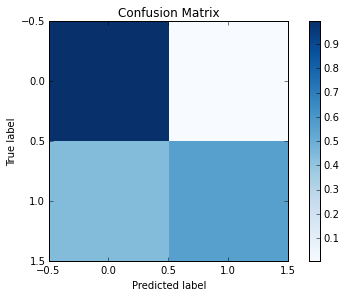

In [74]:
# Compute confusion matrix

y_pred = rf.predict(X_test)
matrix = confusion_matrix(y_test, y_pred)
norm_matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(norm_matrix)
plt.figure()
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plot_confusion_matrix(norm_matrix, title='Confusion Matrix')


In [49]:
# Compare probabilities to predictions
count = 0
length = 0

# There is probably a more elegant way to do this
y_prob = rf.predict_proba(X_test)
for i in range(len(y_prob)):
    if y_prob[i][1] > .4:
        length += 1
        if y_pred[i] == True:
            count += 1

print "Percent of churn with predicted probability over 40%", (count/length) 
print "Total number of predictions above threshold:", length
print "Total number of predictions:", len(y_pred)

# This shows us that churn is already fairly low, and may help us understand why our recall
# is so much worse than raw accuracy or precision. We are picking up false negatives which 
# are pushing our recall down

    

Percent of churn with predicted probability over 40% 0.788888888889
Total number of predictions above threshold: 90
Total number of predictions: 834


In [50]:
print "Precision:",precision_score(y_test,y_pred)
print "Recall:",recall_score(y_test,y_pred)


Precision: 0.943661971831
Recall: 0.558333333333


In [27]:
rf_oob = RandomForestClassifier(n_estimators=20,oob_score=True).fit(X_train,y_train)
print "Out of Bag Accuracy:",rf_oob.oob_score_
print "Raw Accuracy:",rf_oob.score(X_test,y_test)

Out of Bag Accuracy: 0.934773909564
Raw Accuracy: 0.955635491607


In [108]:
# Comparisons with a few other models

lr_metrics = []
dt_metrics = []
knn_metrics = []

for train_index,test_index in KFold(len(y),10):
    
    ''' Logistic Regression '''
    lr = LogisticRegression(class_weight='auto').fit(X_smote[train_index],y_smote[train_index])
    lr_metrics.append(cross_val_score(lr,X_smote[test_index],y_smote[test_index]))
    
    ''' Decision Tree '''
    dt = DecisionTreeClassifier(class_weight='auto').fit(X_smote[train_index],y_smote[train_index])
    dt_metrics.append(cross_val_score(dt,X_smote[test_index],y_smote[test_index]))
    

    ''' kNN '''
    knn = KNeighborsClassifier().fit(X_smote[train_index],y_smote[train_index])
    knn_metrics.append(cross_val_score(knn,X_smote[test_index],y_smote[test_index]))

    
    
print "SMOTE Balancing"    
print "LOGISTIC REGRESSION"
print "Accuracy:",np.array(lr_metrics)[:,0].mean()
print "Precision:",np.array(lr_metrics)[:,1].mean()
print "Recall:",np.array(lr_metrics)[:,2].mean()
print ""
print "DECISION TREE"
print "Accuracy:",np.array(dt_metrics)[:,0].mean()
print "Precision:",np.array(dt_metrics)[:,1].mean()
print "Recall:",np.array(dt_metrics)[:,2].mean()
print ""
print "kNN"
print "Accuracy:",np.array(knn_metrics)[:,0].mean()
print "Precision:",np.array(knn_metrics)[:,1].mean()
print "Recall:",np.array(knn_metrics)[:,2].mean()

# These models are sacrificing some precision and accuracy for recall. Given that, as a 
# rule, false negatives will be the most expensive type of error (it is much more expensive to 
# find a new customer than keep an existing one), these models will probably make more 
# business sense

SMOTE Balancing
LOGISTIC REGRESSION
Accuracy: 0.759121621622
Precision: 0.727027027027
Recall: 0.750434070434

DECISION TREE
Accuracy: 0.843291505792
Precision: 0.848648648649
Recall: 0.857166257166

kNN
Accuracy: 0.865773809524
Precision: 0.863963963964
Recall: 0.876027846028


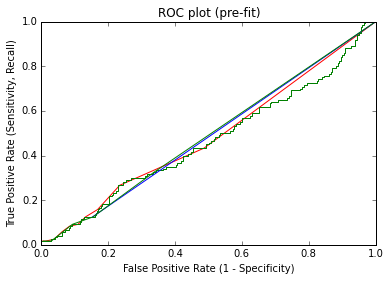

In [72]:
# ROC curve funtion works on predicted probabilities

tpr_rf, fpr_rf = roc_curve(rf,X_test,y_test)
tpr_lr, fpr_lr = roc_curve(lr,X_test,y_test)
tpr_dt, fpr_dt = roc_curve(dt,X_test,y_test)
tpr_knn, fpr_knn = roc_curve(knn,X_test,y_test)

plt.plot(fpr_rf, tpr_rf, c='r') # Random Forest
plt.plot(fpr_lr, tpr_lr, c='g') # Logistic Regression
plt.plot(fpr_dt, tpr_dt, c='b') # Decision Trees
plt.plot(fpr_knn, tpr_knn, c='g') # kNN

plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.title("ROC plot (pre-fit)");

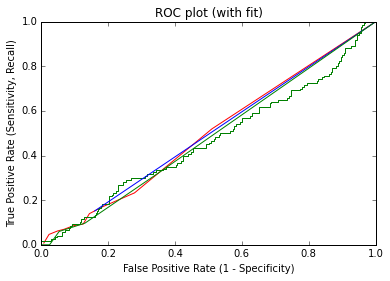

In [73]:
tpr_rf, fpr_rf = roc_curve(RandomForestClassifier,X,y,fit=True)
tpr_lr, fpr_lr = roc_curve(lr,X_test,y_test)
tpr_dt, fpr_dt = roc_curve(DecisionTreeClassifier,X,y,fit=True)
tpr_knn, fpr_knn = roc_curve(KNeighborsClassifier,X,y,fit=True)

plt.plot(fpr_rf, tpr_rf, c='r') # Random Forest
plt.plot(fpr_lr, tpr_lr, c='g') # Logistic Regression
plt.plot(fpr_dt, tpr_dt, c='b') # Decision Trees
plt.plot(fpr_knn, tpr_knn, c='g') # kNN

plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.title("ROC plot (with fit)");